Training model with dropout_rate=0.2, lstm_units=50


c:\Users\DELL\anaconda3\envs\solar_prediction\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 88s 10ms/step - loss: 0.0162 - val_loss: 0.0205
Epoch 2/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - loss: 0.0141 - val_loss: 0.0209
Epoch 3/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - loss: 0.0139 - val_loss: 0.0201
Epoch 4/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 0.0137 - val_loss: 0.0203
Epoch 5/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 0.0135 - val_loss: 0.0200
Epoch 6/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - loss: 0.0134 - val_loss: 0.0201
Epoch 7/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 94s 11ms/step - loss: 0.0131 - val_loss: 0.0197
Epoch 8/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 94s 11ms/step - loss: 0.0130 - val_loss: 0.0214
Epoch 9/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - loss: 0.0129 - val_loss: 0.0206
Epoch 10/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step - loss: 0.0128 - val_loss: 0.0201
Epoch 11/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - loss: 0.0126 - val_loss: 0.0202
Epoch 12

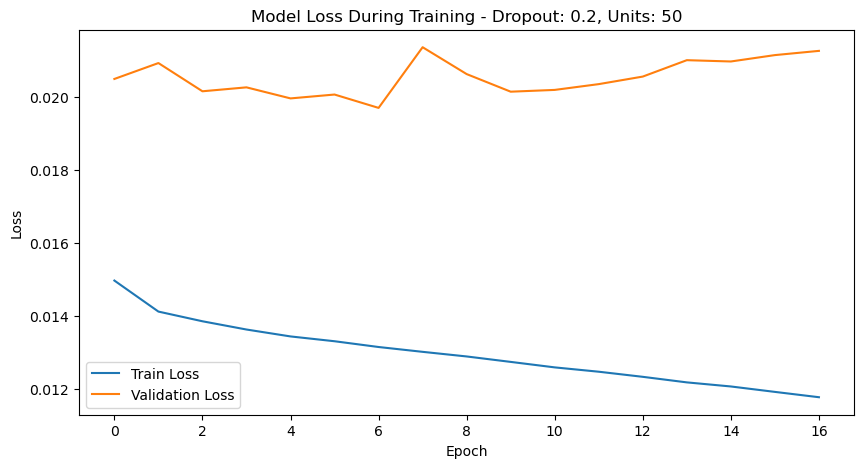

In [ ]:
##########################Final 15min Model#####################################################################################
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# Load the data
file_path = r"D:\Group Project\Train 12.00AM 3-10.5.xlsx"
data = pd.read_excel(file_path, parse_dates=['Time'])

# Initialize separate scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# List of feature and target columns
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Apply feature scaler to the feature columns
data[features_to_scale] = feature_scaler.fit_transform(data[features_to_scale])

# Apply target scaler to the target column
data[[output_column]] = target_scaler.fit_transform(data[[output_column]])

# Save the scalers
joblib.dump(feature_scaler, 'feature_scalerNew.pkl')
joblib.dump(target_scaler, 'target_scalerNew.pkl')

# Prepare input and output data for the LSTM
sequence_length = 15  # Past time steps used as input
prediction_length = 15  # Future steps to predict

def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data.iloc[i:i+sequence_length][features_to_scale].values)
        y.append(target_data.iloc[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, data, sequence_length, prediction_length)

# Define and compile the LSTM model
def build_model(dropout_rate=0.2, lstm_units=50):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=True), input_shape=(sequence_length, len(features_to_scale))),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh'),
        Dense(prediction_length)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Early stopping to prevent overfitting
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model for the specific hyperparameters
dropout_rate = 0.2
lstm_units = 50
print(f"Training model with dropout_rate={dropout_rate}, lstm_units={lstm_units}")
model = build_model(dropout_rate, lstm_units)
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss During Training - Dropout: {dropout_rate}, Units: {lstm_units}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save the trained model
model.save('optimized_lstm_modeldeNew.h5')


3465/3465 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
Mean Squared Error on Test Data: 1.6692789170842641


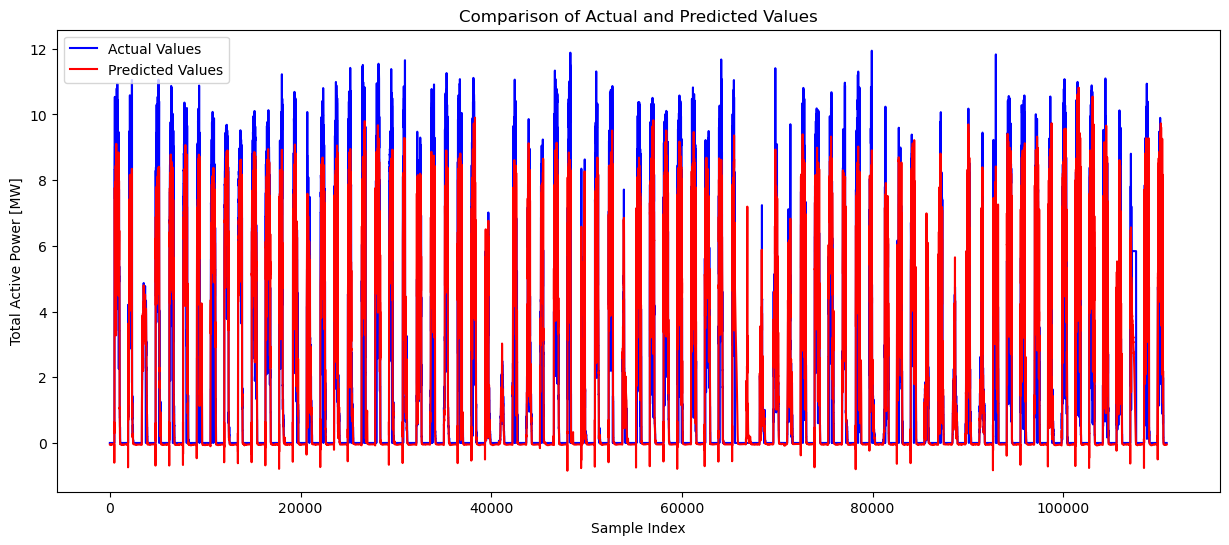

In [ ]:
####################################Testing Code###################################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model

# Load the test data
test_file_path = r"D:\Group Project\Test 12.00AM 3-10.5.xlsx"
test_data = pd.read_excel(test_file_path, parse_dates=['Time'])

# Load the saved scalers
feature_scaler = joblib.load('feature_scalerNew.pkl')
target_scaler = joblib.load('target_scalerNew.pkl')

# Apply the feature scaler to the test data
test_data[features_to_scale] = feature_scaler.transform(test_data[features_to_scale])

# Apply the target scaler to the test data
test_data[[output_column]] = target_scaler.transform(test_data[[output_column]])

# Generate sequences from the test data
def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data[i:i+sequence_length][features_to_scale].values)
        y.append(target_data[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

X_test, y_test = create_sequences(test_data, test_data, sequence_length, prediction_length)

# Load the trained model
model = load_model('optimized_lstm_modeldeNew.h5')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to compare them in their original scale
predictions_inverse = target_scaler.inverse_transform(predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_inverse, predictions_inverse)
print(f"Mean Squared Error on Test Data: {mse}")

# Optionally, plot the first few predicted vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_test_inverse[:, 0], label='Actual Values', color='blue')  # change index for different steps
plt.plot(predictions_inverse[:, 0], label='Predicted Values', color='red')  # change index for different prediction steps
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Total Active Power [MW]')
plt.legend()
plt.show()


3465/3465 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step
Mean Squared Error (MSE) on Test Data: 1.6692789170842641
Root Mean Squared Error (RMSE) on Test Data: 1.2920057728525303
Mean Absolute Error (MAE) on Test Data: 0.5789599531074604
R-squared (R2) on Test Data: 0.8114389379008045


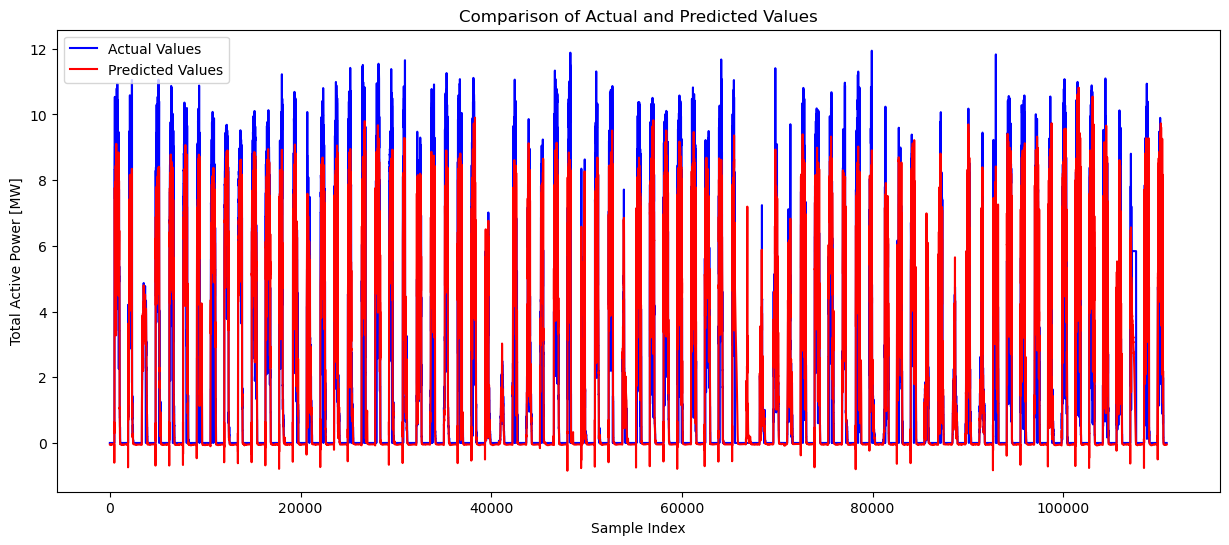

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the test data
test_file_path = r"D:\Group Project\Test 12.00AM 3-10.5.xlsx"
test_data = pd.read_excel(test_file_path, parse_dates=['Time'])

# Load the saved scalers
feature_scaler = joblib.load('feature_scalerNew.pkl')
target_scaler = joblib.load('target_scalerNew.pkl')

# List of feature and target columns
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Apply the feature scaler to the test data
test_data[features_to_scale] = feature_scaler.transform(test_data[features_to_scale])

# Apply the target scaler to the target column
test_data[[output_column]] = target_scaler.transform(test_data[[output_column]])

# Generate sequences from the test data
def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data[i:i+sequence_length][features_to_scale].values)
        y.append(target_data[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

sequence_length = 15  # Past time steps used as input
prediction_length = 15  # Future steps to predict

X_test, y_test = create_sequences(test_data, test_data, sequence_length, prediction_length)

# Load the trained model
model = load_model('optimized_lstm_modeldeNew.h5')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to compare them in their original scale
predictions_inverse = target_scaler.inverse_transform(predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
r2 = r2_score(y_test_inverse, predictions_inverse)

# Print the performance metrics
print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R2) on Test Data: {r2}")

# Optionally, plot the first few predicted vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_test_inverse[:, 0], label='Actual Values', color='blue')  # change index for different steps
plt.plot(predictions_inverse[:, 0], label='Predicted Values', color='red')  # change index for different prediction steps
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Total Active Power [MW]')
plt.legend()
plt.show()


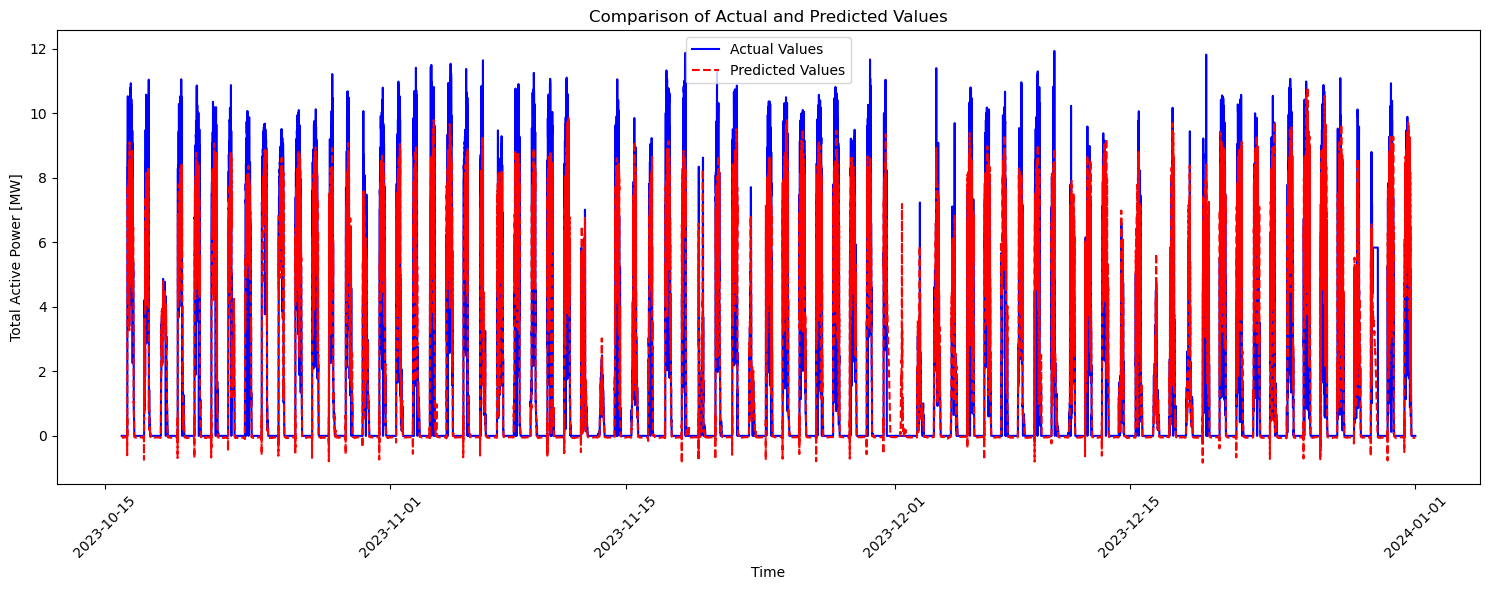

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming all previous steps are the same...

# Extract the timestamps corresponding to the starting points of the predictions
timestamps = test_data['Time'][sequence_length:-prediction_length+1].reset_index(drop=True)

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y_test_inverse[:, 0], label='Actual Values',linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps, predictions_inverse[:, 0], label='Predicted Values',linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


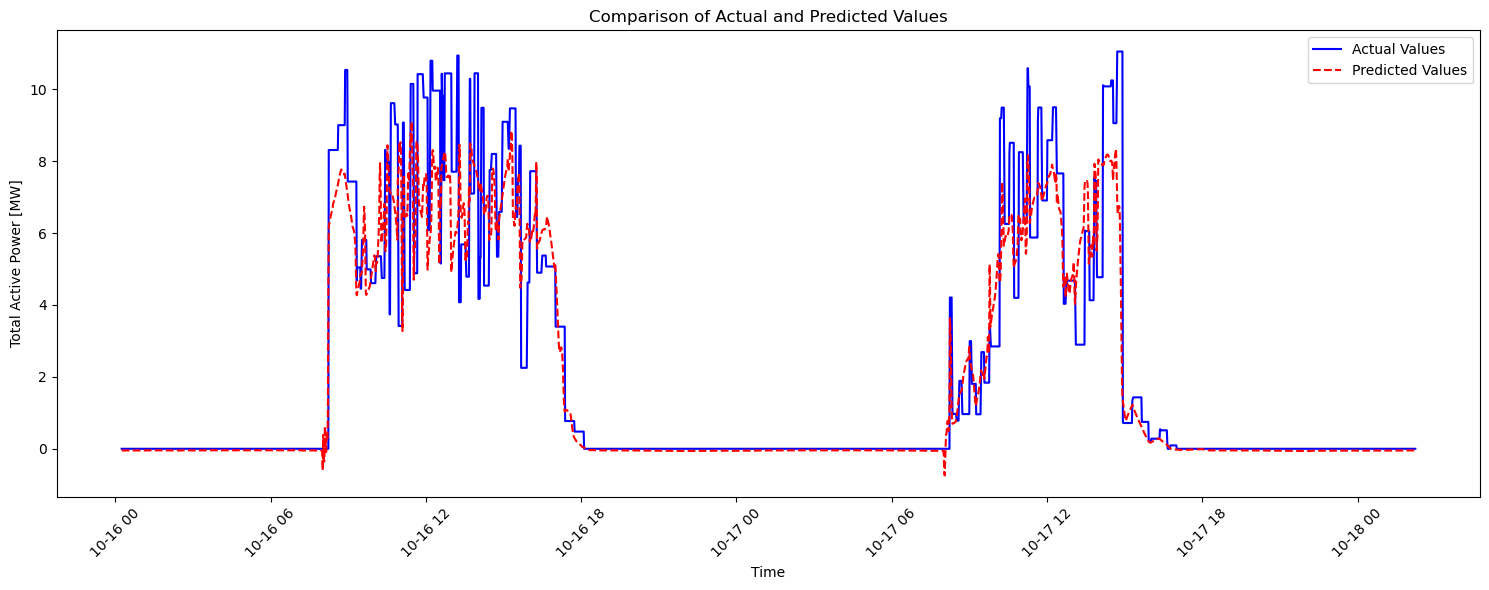

In [7]:
import matplotlib.pyplot as plt

# Extract the timestamps corresponding to the starting points of the predictions
timestamps = test_data['Time'][sequence_length:-prediction_length+1].reset_index(drop=True)

# Number of points to display
num_points = 3000

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps[:num_points], y_test_inverse[:num_points, 0], label='Actual Values', linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps[:num_points], predictions_inverse[:num_points, 0], label='Predicted Values', linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

def predict_next_15_minutes(model, feature_scaler, target_scaler, custom_input):
    """
    Predict the Total Power Output for the next 15 minutes using an LSTM model.

    Parameters:
    - model: Loaded LSTM model.
    - feature_scaler: Scaler used for input features.
    - target_scaler: Scaler used for output feature.
    - custom_input: DataFrame containing the last N input features where N is the sequence length required by the model.

    Returns:
    - DataFrame containing predictions for the next 15 minutes.
    """
    # Scale the input features
    scaled_features = feature_scaler.transform(custom_input[['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']])
    # Reshape data for LSTM [samples, timesteps, features]
    X_new = np.array([scaled_features])

    # Make prediction
    pred_scaled = model.predict(X_new)
    predictions = target_scaler.inverse_transform(pred_scaled)[0]  # Assuming the model outputs all 15 steps at once

    # Create a DataFrame for the predictions
    prediction_times = [custom_input['Datetime'].iloc[0] + pd.Timedelta(minutes=i) for i in range(1, 16)]
    prediction_df = pd.DataFrame({
        'Datetime': prediction_times,
        'Predicted_TOTAL_ACTIVE_POWER': predictions
    })

    return prediction_df




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step

Predicted TOTAL_ACTIVE_POWER for the next 15 minutes:
              Datetime  Predicted_TOTAL_ACTIVE_POWER
0  2023-10-20 10:47:00                      7.119766
1  2023-10-20 10:48:00                      6.997504
2  2023-10-20 10:49:00                      6.839906
3  2023-10-20 10:50:00                      6.965658
4  2023-10-20 10:51:00                      6.795433
5  2023-10-20 10:52:00                      6.836349
6  2023-10-20 10:53:00                      6.607498
7  2023-10-20 10:54:00                      6.538194
8  2023-10-20 10:55:00                      6.332440
9  2023-10-20 10:56:00                      6.356159
10 2023-10-20 10:57:00                      6.401067
11 2023-10-20 10:58:00                      6.494269
12 2023-10-20 10:59:00                      6.776068
13 2023-10-20 11:00:00                      6.903001
14 2023-10-20 11:01:00                      6.921104


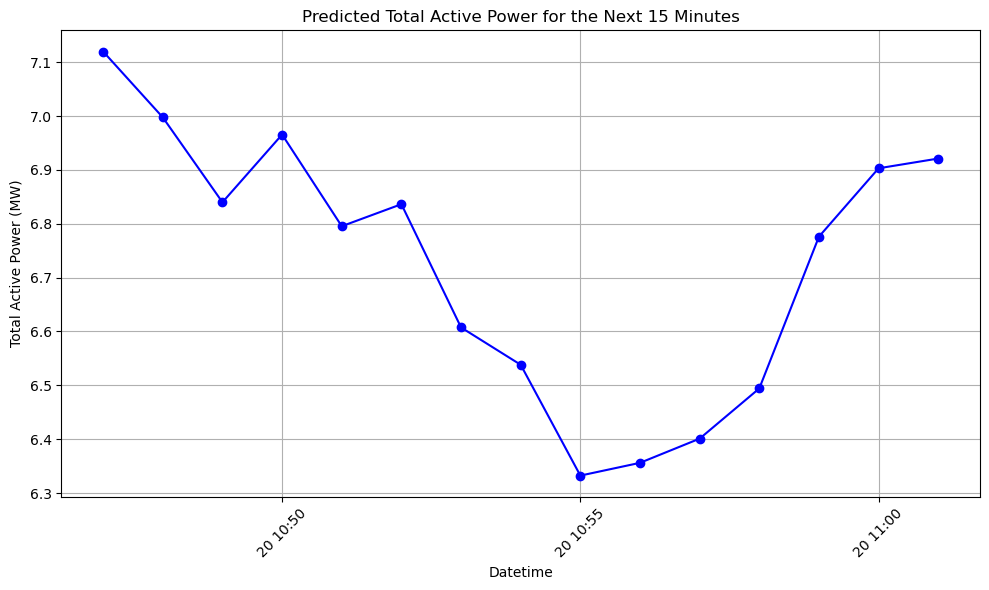

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

def predict_next_15_minutes(model, feature_scaler, target_scaler, custom_input):
    """
    Predict the Total Power Output for the next 15 minutes using an LSTM model.

    Parameters:
    - model: Loaded LSTM model.
    - feature_scaler: Scaler used for input features.
    - target_scaler: Scaler used for output feature.
    - custom_input: DataFrame containing the required sequence of input features.

    Returns:
    - DataFrame containing predictions for the next 15 minutes.
    """
    # Ensure custom_input is a DataFrame
    if isinstance(custom_input, dict):
        custom_input = pd.DataFrame([custom_input])  # Convert dict to DataFrame

    # Add necessary datetime features if missing
    if 'Datetime' in custom_input:
        custom_input.index = pd.to_datetime(custom_input['Datetime'])  # Set datetime as index
        custom_input.drop('Datetime', axis=1, inplace=True)

    # Scale the input features
    scaled_features = feature_scaler.transform(custom_input)
    
    # Reshape data for LSTM [samples, timesteps, features]
    X_new = np.expand_dims(scaled_features, axis=0)

    # Make prediction
    pred_scaled = model.predict(X_new)
    predictions = target_scaler.inverse_transform(pred_scaled)[0]  # Assuming the model outputs all 15 steps at once

    # Create a DataFrame for the predictions
    prediction_times = [custom_input.index[-1] + pd.Timedelta(minutes=i+1) for i in range(15)]
    prediction_df = pd.DataFrame({
        'Datetime': prediction_times,
        'Predicted_TOTAL_ACTIVE_POWER': predictions
    })

    return prediction_df

# Usage example:
model = load_model('optimized_lstm_modeldeNew.h5')
feature_scaler = joblib.load('feature_scalerNew.pkl')
target_scaler = joblib.load('target_scalerNew.pkl')

# Define custom input
custom_input = {
    'Irradiation': 900.611441,
    'Temp': 28.2,
    'Wind': 10.8,
    'Humidity': 0.781,
    'Barometer': 1000.1,
    'Datetime': pd.to_datetime('2023-10-20 10:46:00')  # Exact date and time
}

# Ensure the custom input has enough data points (15 points required)
custom_input_df = pd.DataFrame([custom_input] * 15)  # Repeat the single observation to fill the sequence

# Make predictions for the next 15 minutes
predicted_df = predict_next_15_minutes(model, feature_scaler, target_scaler, custom_input_df)
print("\nPredicted TOTAL_ACTIVE_POWER for the next 15 minutes:")
print(predicted_df)

import matplotlib.pyplot as plt

# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(predicted_df['Datetime'], predicted_df['Predicted_TOTAL_ACTIVE_POWER'], marker='o', linestyle='-', color='b')
plt.title('Predicted Total Active Power for the Next 15 Minutes')
plt.xlabel('Datetime')
plt.ylabel('Total Active Power (MW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


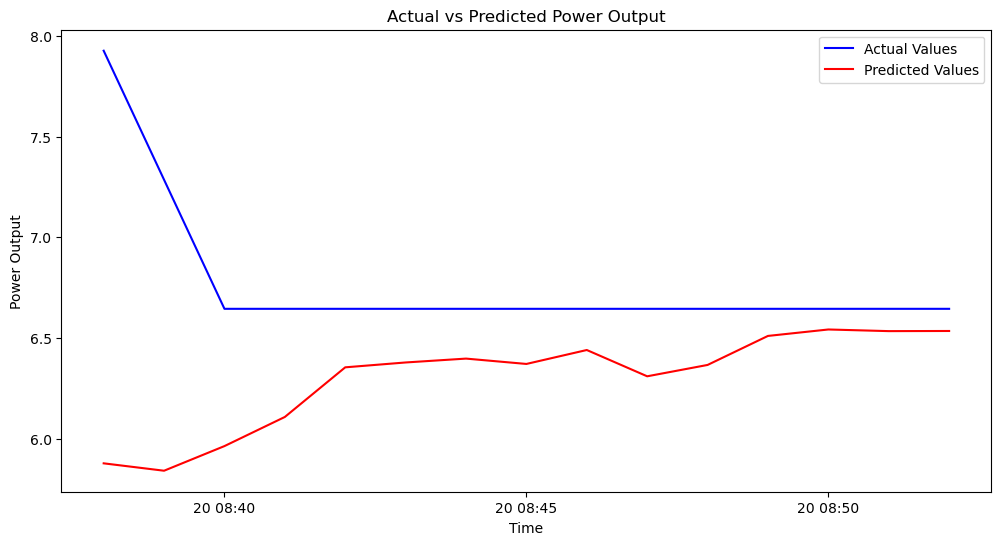

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved model and scalers
model = load_model('optimized_lstm_modeldeNew.h5')
feature_scaler = joblib.load('feature_scalerNew.pkl')
target_scaler = joblib.load('target_scalerNew.pkl')

# Define the features to scale and the output column
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Load the test data
test_data = pd.read_excel(r"D:\Group Project\Test 12.00AM 3-10.5.xlsx", parse_dates=['Time'])

# Select a specific datetime for prediction
selected_datetime = pd.Timestamp('2023-11-20 08:37:00')
sequence_length = 15  # You need 15 past points to predict the future

# Check if selected_datetime is in test_data
if selected_datetime in test_data['Time'].values:
    idx = test_data[test_data['Time'] == selected_datetime].index[0]

    # Ensure there are enough previous records to form a full sequence
    if idx >= sequence_length - 1:
        input_sequence = test_data.iloc[idx-sequence_length+1:idx+1]
        input_features = input_sequence[features_to_scale]  # Assuming these are your input features

        # Scale the input features
        scaled_features = feature_scaler.transform(input_features)

        # Reshape data for LSTM [samples, timesteps, features]
        X_new = scaled_features.reshape(1, sequence_length, len(features_to_scale))

        # Make prediction
        pred_scaled = model.predict(X_new)
        predictions = target_scaler.inverse_transform(pred_scaled)[0]

        # Combine predictions with actual data for comparison
        actual_data = test_data.iloc[idx+1:idx+1+sequence_length][output_column].values
        times = input_sequence['Time'].iloc[-1] + pd.to_timedelta(np.arange(1, sequence_length+1), unit='m')

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(times, actual_data, label='Actual Values', color='blue')
        plt.plot(times, predictions, label='Predicted Values', color='red')
        plt.title('Actual vs Predicted Power Output')
        plt.xlabel('Time')
        plt.ylabel('Power Output')
        plt.legend()
        plt.show()
    else:
        print("Not enough data points before the selected datetime to make a prediction.")
else:
    print(f"The selected datetime {selected_datetime} is not available in the dataset.")


Training model with dropout_rate=0.2, lstm_units=50
Epoch 1/50


c:\Users\DELL\anaconda3\envs\solar_prediction\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8244/8244 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - loss: 0.0167 - val_loss: 0.0211
Epoch 2/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 0.0142 - val_loss: 0.0206
Epoch 3/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - loss: 0.0139 - val_loss: 0.0203
Epoch 4/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - loss: 0.0136 - val_loss: 0.0200
Epoch 5/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - loss: 0.0136 - val_loss: 0.0223
Epoch 6/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 0.0132 - val_loss: 0.0207
Epoch 7/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 0.0131 - val_loss: 0.0201
Epoch 8/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 89s 11ms/step - loss: 0.0130 - val_loss: 0.0214
Epoch 9/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 90s 11ms/step - loss: 0.0129 - val_loss: 0.0207
Epoch 10/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 92s 11ms/step - loss: 0.0128 - val_loss: 0.0199
Epoch 11/50
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 1598s 194ms/step - loss: 0.0127 - val_loss: 0.0203
Epoch 12/50
8244

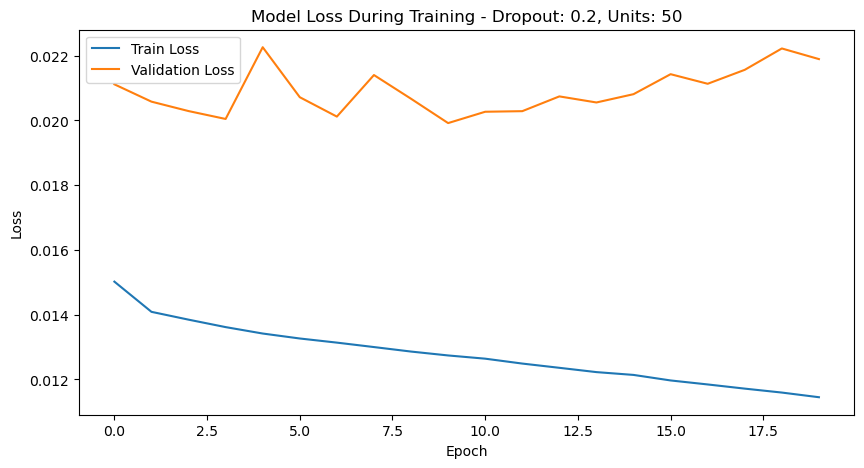

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# Load the data
file_path = r"D:\Group Project\Train 12.00AM 3-10.5.xlsx"
data = pd.read_excel(file_path, parse_dates=['Time'])

# Initialize separate scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# List of feature and target columns
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Apply feature scaler to the feature columns
data[features_to_scale] = feature_scaler.fit_transform(data[features_to_scale])

# Apply target scaler to the target column
data[[output_column]] = target_scaler.fit_transform(data[[output_column]])

# Save the scalers
joblib.dump(feature_scaler, 'feature_scalerNew1.pkl')
joblib.dump(target_scaler, 'target_scalerNew1.pkl')

# Prepare input and output data for the LSTM
sequence_length = 15  # Past time steps used as input
prediction_length = 15  # Future steps to predict

def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data.iloc[i:i+sequence_length][features_to_scale].values)
        y.append(target_data.iloc[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, data, sequence_length, prediction_length)

# Define and compile the LSTM model
def build_model(dropout_rate=0.2, lstm_units=50, additional_layer=False):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=True), input_shape=(sequence_length, len(features_to_scale))),
        Dropout(dropout_rate)
    ])
    if additional_layer:
        model.add(LSTM(lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(Dense(prediction_length))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Early stopping to prevent overfitting
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model for the specific hyperparameters
dropout_rate = 0.2
lstm_units = 50
print(f"Training model with dropout_rate={dropout_rate}, lstm_units={lstm_units}")
model = build_model(dropout_rate, lstm_units)
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss During Training - Dropout: {dropout_rate}, Units: {lstm_units}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save the trained model
model.save('optimized_lstm_modeldeNew1.h5')


3465/3465 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Mean Squared Error (MSE) on Test Data: 1.6919839370138854
Root Mean Squared Error (RMSE) on Test Data: 1.3007628288869133
Mean Absolute Error (MAE) on Test Data: 0.5809825464448297
R-squared (R2) on Test Data: 0.8088741881582086


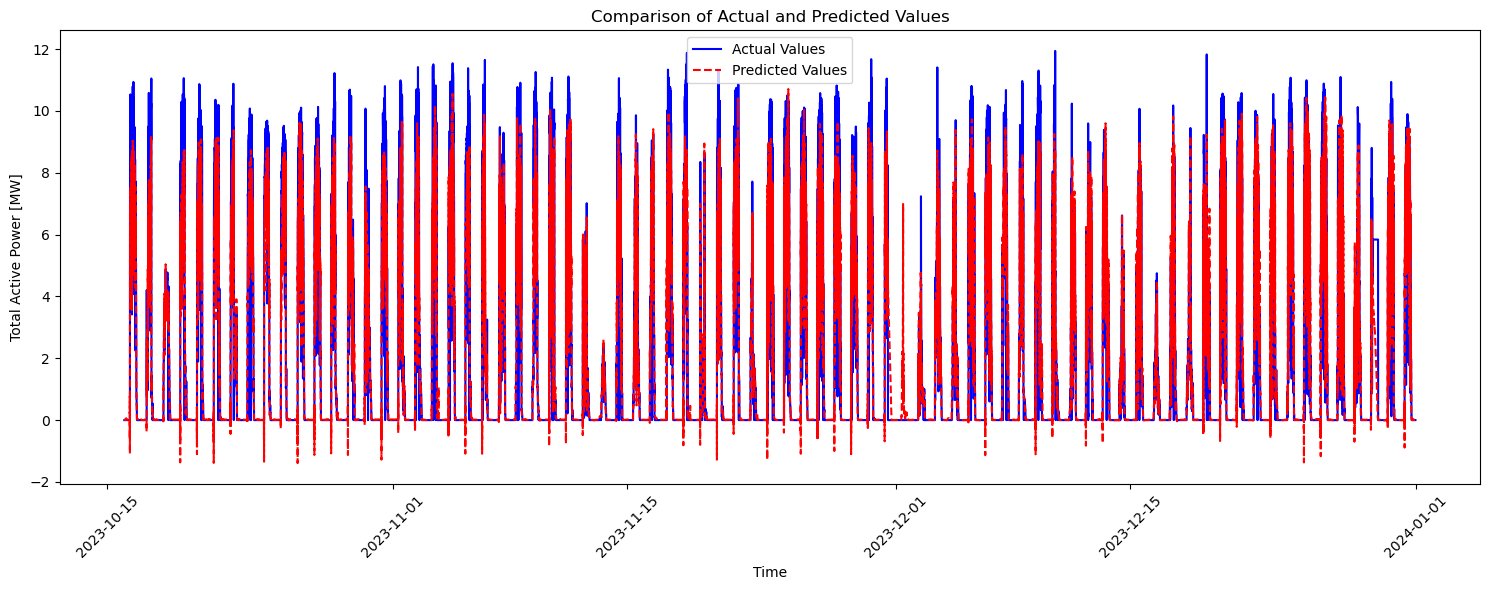

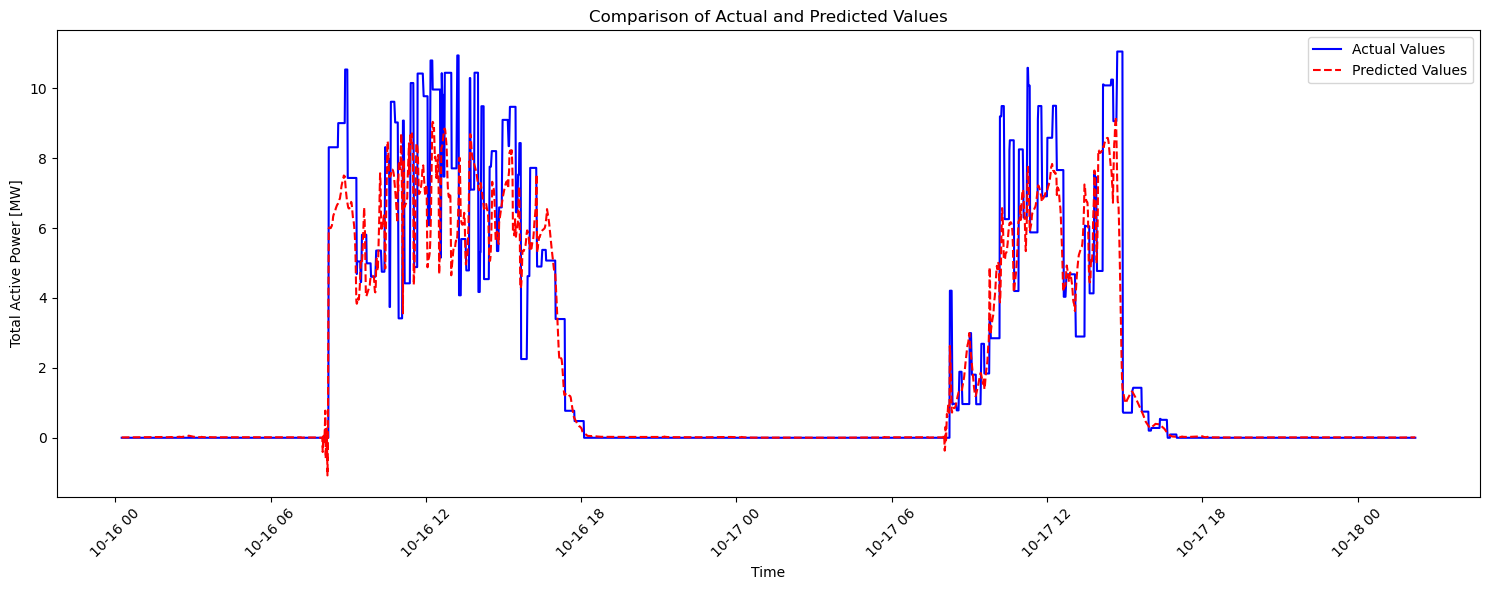

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the test data
test_file_path = r"D:\Group Project\Test 12.00AM 3-10.5.xlsx"
test_data = pd.read_excel(test_file_path, parse_dates=['Time'])

# Load the saved scalers
feature_scaler = joblib.load('feature_scalerNew1.pkl')
target_scaler = joblib.load('target_scalerNew1.pkl')

# List of feature and target columns
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Apply the feature scaler to the test data
test_data[features_to_scale] = feature_scaler.transform(test_data[features_to_scale])

# Apply the target scaler to the target column
test_data[[output_column]] = target_scaler.transform(test_data[[output_column]])

# Generate sequences from the test data
def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data[i:i+sequence_length][features_to_scale].values)
        y.append(target_data[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

sequence_length = 15  # Past time steps used as input
prediction_length = 15  # Future steps to predict

X_test, y_test = create_sequences(test_data, test_data, sequence_length, prediction_length)

# Load the trained model
model = load_model('optimized_lstm_modeldeNew1.h5')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to compare them in their original scale
predictions_inverse = target_scaler.inverse_transform(predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
r2 = r2_score(y_test_inverse, predictions_inverse)

# Print the performance metrics
print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R2) on Test Data: {r2}")

# Extract the timestamps corresponding to the starting points of the predictions
timestamps = test_data['Time'][sequence_length:-prediction_length+1].reset_index(drop=True)

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y_test_inverse[:, 0], label='Actual Values',linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps, predictions_inverse[:, 0], label='Predicted Values',linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


# Number of points to display
num_points = 3000

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps[:num_points], y_test_inverse[:num_points, 0], label='Actual Values', linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps[:num_points], predictions_inverse[:num_points, 0], label='Predicted Values', linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

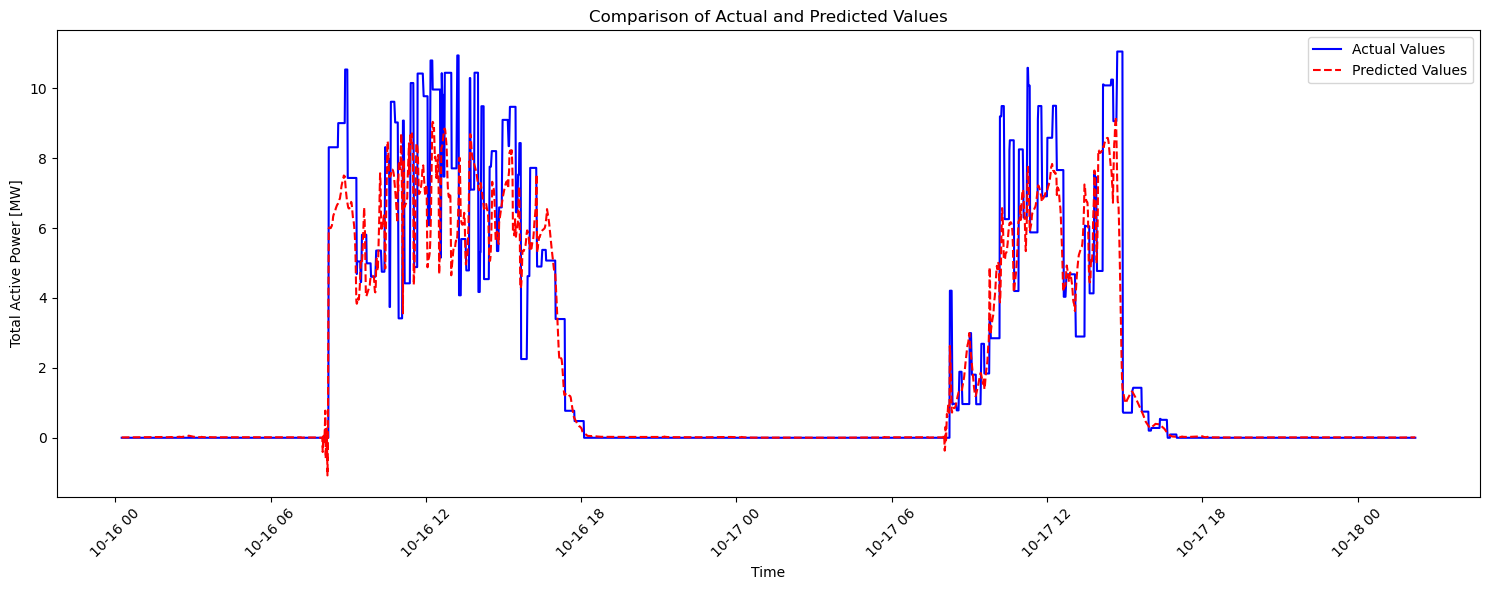

In [17]:
# Number of points to display
num_points = 3000

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps[:num_points], y_test_inverse[:num_points, 0], label='Actual Values', linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps[:num_points], predictions_inverse[:num_points, 0], label='Predicted Values', linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()